# Importing libraries

In [1]:
from sklearn import model_selection, datasets, svm
from qiskit import QuantumCircuit, Aer, IBMQ, QuantumRegister, ClassicalRegister
import numpy as np
import qiskit
import copy
import matplotlib.pyplot as plt
np.random.seed(42)

# Importing the Iris Dataset


In [2]:
iris = datasets.load_iris()
X = iris.data[0:100]
Y = iris.target[0:100]
X_train, X_test, Y_train, Y_test = model_selection.train_test_split(X, Y, test_size=0.33, random_state=42)

# Hyperparameters

In [3]:
N = 4

# Designing the circuit

In [4]:
def feature_map(X, encoding_type):
    q = QuantumRegister(N)
    c = ClassicalRegister(1)
    qc = QuantumCircuit(q, c)
    if encoding_type == 'rx':
        for i, x in enumerate(X):
            qc.rx(x, i)
    elif encoding_type == 'ry':
        for i, x in enumerate(X):
            qc.ry(x, i)
    elif encoding_type == 'rz':
        for i, x in enumerate(X):
            qc.rz(x, i)    
    return qc, c

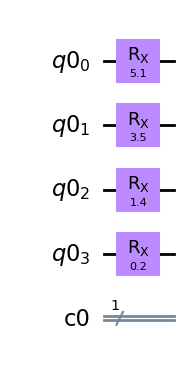

In [5]:
# feature map test
qc,c = feature_map(X[0], 'rx')
qc.draw('mpl')

# Using entanglment and parameteristaion

In [6]:
def variational_circuit(qc, theta, rotation_type):
    
    for i in range(N-1):
        qc.cnot(i, i+1)
    qc.cnot(N-1, 0)
    
    if rotation_type == 'rx':
        for i in range(N):
            qc.rx(theta[i], i)
    elif rotation_type == 'ry':
        for i in range(N):
            qc.ry(theta[i], i)
    elif rotation_type == 'rz':
        for i in range(N):
            qc.rz(theta[i], i)
            
    return qc

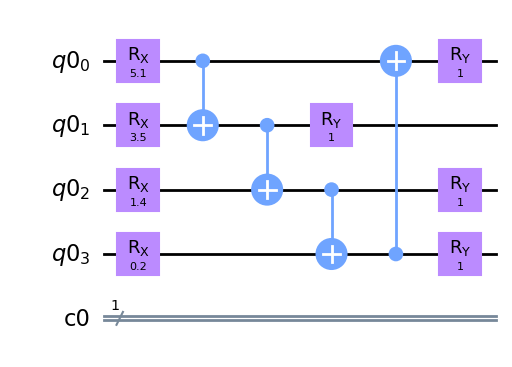

In [7]:
qc = variational_circuit(qc, np.ones(4), 'ry')
qc.draw('mpl')

# Defining the algorithm

In [8]:
def quantum_nn(X, theta, shots, encoding_type, rotation_type, simulator=True):
    
    qc, c = feature_map(X, encoding_type)
    qc = variational_circuit(qc, theta, rotation_type)
    qc.measure(0, c)

    backend = Aer.get_backend('qasm_simulator')
    
    if simulator == False:
        provider = IBMQ.load_account()
        backend = provider.get_backend('ibm_oslo')
        
    job = qiskit.execute(qc, backend, shots=shots)
    result = job.result()
    counts = result.get_counts(qc)
    
    return counts['1']/shots


In [9]:
qc, c = feature_map(X[0], 'rz')
qc = variational_circuit(qc, np.ones(4), 'rz')
qc.measure(0, c)
backend = Aer.get_backend('qasm_simulator')
    
job = qiskit.execute(qc, backend, shots=5000)
result = job.result()
counts = result.get_counts(qc)
print(counts)

{'0': 5000}


In [10]:
# quantum_nn test
quantum_nn(X[0], np.ones(4), 5000, 'rx', 'ry')

0.5412

# Defining the loss function

In [11]:
def loss(prediction, target):
    return(prediction-target)**2

In [ ]:
# loss test
loss(quantum_nn(X[0], [0.9, 0.9, 0.9, 0.9], 5000, 'rx', 'ry'), Y[0])

# Defining the gradient function (gradient descent)

In [ ]:
def gradient(X, Y, theta, delta, shots, encoding_type, rotation_type):

    grad = []
    for i in range(len(theta)):
        
        dtheta = copy.copy(theta)
        dtheta[i] += delta
        
        prediction_1 = quantum_nn(X, dtheta, shots, encoding_type, rotation_type)
        prediction_2 = quantum_nn(X, theta, shots, encoding_type, rotation_type)
        
        grad.append((loss(prediction_1, Y) - loss(prediction_2, Y)) / delta)
        
    return np.array(grad)

In [ ]:
gradient(X[0], Y[0], np.ones(4), 0.01, 5000, 'rx', 'ry')

# Defining Accuracy function

In [ ]:
def accuracy(X, Y, theta, shots, encoding_type, rotation_type):
    
    counter = 0
    for X_i, Y_i, in zip(X, Y):
        prediction = quantum_nn(X_i, theta, shots, encoding_type, rotation_type)
        
        if prediction < 0.5 and Y_i == 0:
            counter += 1
        elif prediction >= 0.5 and Y_i == 1:
            counter += 1
            
    return counter/len(Y)

In [ ]:
# Accuracy test
accuracy(X, Y, [-1.5, 1.2, 0.6, -0.2], 5000, 'rx', 'ry')

In [ ]:
def get_best_weight(accuracies, weights):
    return(weights[accuracies.index(max(accuracies))])

# Training

# Test 1

In [ ]:

N = 4
def model(x_train, y_train, x_test, y_test, learning_rate, epochs, theta, shots, encoding_type, rotation_type, delta, optimizing_weights=False):
    loss_list = []
    acc_list = []
    weights_list = []

    print('Epoch \t Loss \t Training Accuracy \t theta')

    for i in range(epochs):
        loss_tmp = []


        for X_i, Y_i in zip(x_train, y_train):


            prediction = quantum_nn(X_i, theta, shots, encoding_type, rotation_type)
            loss_tmp.append(loss(prediction, Y_i))
            # update theta
            new_theta = theta - learning_rate * gradient(X_i, Y_i, theta, delta, shots, encoding_type, rotation_type)

            if loss(quantum_nn(X_i, new_theta, shots, encoding_type, rotation_type), Y_i) < loss(quantum_nn(X_i, theta, shots, encoding_type, rotation_type), Y_i):
                theta = new_theta

        loss_list.append(np.mean(loss_tmp))
        acc_list.append(accuracy(X_train, Y_train, theta, shots, encoding_type, rotation_type))
        weights_list.append(theta)
        
        print(f'{i} \t {round(loss_list[-1], 3)} \t {round(acc_list[-1], 3)} \t {theta} \t {len(weights_list)}')
    
    if optimizing_weights==True:
        acc = accuracy(x_test, y_test, get_best_weight(acc_list, weights_list), shots, encoding_type=encoding_gate, rotation_type=rotation_gate)
        return acc, get_best_weight(acc_list, weights_list), theta, loss_list, acc_list, weights_list
    else:
        acc = accuracy(x_test, y_test, theta, shots, encoding_type=encoding_gate, rotation_type=rotation_gate)
        return acc, theta, loss_list, acc_list, weights_list

In [ ]:
gates = ['rx', 'ry', 'rz']
results = {}
for encoding_gate in gates:
    for rotation_gate in gates:
        circuit_type = encoding_gate + '-' + rotation_gate
        if circuit_type != 'rz-rz':
            print(f'Circuit type : {circuit_type} -> encoding : {encoding_gate} rotation : {rotation_gate}')
            acc, theta, loss_list, acc_list, weights_history = model(X_train, Y_train, X_test, Y_test, learning_rate=0.05, epochs=10, theta=np.ones(N), shots=5000, encoding_type=encoding_gate, rotation_type=rotation_gate, delta=0.01)
            results.update({circuit_type: {'accuracy': acc, 'theta': theta, 'loss_list':loss_list, 'acc_list':acc_list, 'weights_history_list':weights_history}})
            print(f" {circuit_type} accuracy : {results.get(circuit_type).get('accuracy')}")

In [ ]:
gates = ['rx', 'ry', 'rz']
labels = []
accuracies = []
for encoding_gate in gates:
    for rotation_gate in gates:
        circuit_type = encoding_gate + '-' + rotation_gate
        if circuit_type != 'rz-rz':
            labels.append(circuit_type)
            accuracies.append(results.get(circuit_type).get('accuracy'))
            
plt.bar(labels, accuracies)
plt.show()

In [ ]:
gates = ['rx', 'ry', 'rz']
labels = []
accuracies = []
for encoding_gate in gates:
    for rotation_gate in gates:
        circuit_type = encoding_gate + '-' + rotation_gate
        if circuit_type != 'rz-rz':
            plt.plot([x for x in range(1, 11)], results.get(circuit_type).get('acc_list'), label=circuit_type)
            
plt.xticks([x for x in range(1, 11)])
plt.yticks(np.arange (0, 1.1, 0.1))
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Circuit Type accuracy effect')
plt.legend()
plt.show()

In [ ]:

N = 4
def model_1(x_train, y_train, x_test, y_test, learning_rate, epochs, theta, shots, encoding_type, rotation_type, delta, optimizing_weights=False):
    loss_list = []
    acc_list = []
    weights_list = []
    loss_val = 1
    i = 0
    print('Epoch \t Loss \t Training Accuracy \t theta')

    while loss_val > 0.1:
        
        loss_tmp = []


        for X_i, Y_i in zip(x_train, y_train):


            prediction = quantum_nn(X_i, theta, shots, encoding_type, rotation_type)
            loss_tmp.append(loss(prediction, Y_i))
            # update theta
            new_theta = theta - learning_rate * gradient(X_i, Y_i, theta, delta, shots, encoding_type, rotation_type)

            if loss(quantum_nn(X_i, new_theta, shots, encoding_type, rotation_type), Y_i) < loss(quantum_nn(X_i, theta, shots, encoding_type, rotation_type), Y_i):
                theta = new_theta
        loss_val = np.mean(loss_tmp)
        loss_list.append(np.mean(loss_tmp))
        acc_list.append(accuracy(X_train, Y_train, theta, shots, encoding_type, rotation_type))
        weights_list.append(theta)
        
        print(f'{i} \t {round(loss_list[-1], 3)} \t {round(acc_list[-1], 3)} \t {theta} \t {len(weights_list)}')
        i = i + 1
    
    return theta, loss_list, acc_list, weights_list

In [ ]:
theta, loss_list, acc_list, weights_history = model_1(X_train, Y_train, X_test, Y_test, learning_rate=0.05, epochs=20, theta=np.ones(N), shots=5000, encoding_type='ry', rotation_type='ry', delta=0.01)

In [ ]:

N = 4
def model_2(x_train, y_train, x_test, y_test, learning_rate, epochs, theta, shots, encoding_type, rotation_type, delta, optimizing_weights=False):
    loss_list = []
    acc_list = []
    weights_list = []

    print('Epoch \t Loss \t Training Accuracy \t theta')

    for i in range(epochs):
        loss_tmp = []


        for X_i, Y_i in zip(x_train, y_train):


            prediction = quantum_nn(X_i, theta, shots, encoding_type, rotation_type)
            loss_tmp.append(loss(prediction, Y_i))
            # update theta
            new_theta = theta - learning_rate * gradient(X_i, Y_i, theta, delta, shots, encoding_type, rotation_type)

            if loss(quantum_nn(X_i, new_theta, shots, encoding_type, rotation_type), Y_i) < loss(quantum_nn(X_i, theta, shots, encoding_type, rotation_type), Y_i):
                theta = new_theta

        loss_list.append(np.mean(loss_tmp))
        acc_list.append(accuracy(X_train, Y_train, theta, shots, encoding_type, rotation_type))
        weights_list.append(theta)
        
        print(f'{i} \t {round(loss_list[-1], 3)} \t {round(acc_list[-1], 3)} \t {theta} \t {len(weights_list)}')
    
    return theta, loss_list, acc_list, weights_list

In [ ]:
for learning_rate in [0.001, 0.01, 0.05, 0.1]:
    theta, loss_list, acc_list, weights_history = model_2(X_train, Y_train, X_test, Y_test, learning_rate=learning_rate, epochs=20, theta=np.ones(N), shots=5000, encoding_type='ry', rotation_type='ry', delta=0.01)
    acc = accuracy(X_test, Y_test, theta, 5000, encoding_type='ry', rotation_type='ry')
    results.update({learning_rate: {'accuracy': acc, 'theta': theta, 'loss_list':loss_list, 'acc_list':acc_list, 'weights_history_list':weights_history}})
    print(f" Learning rate : {learning_rate} accuracy : {results.get(learning_rate).get('accuracy')}")

In [ ]:
learning_rates = [0.001, 0.01, 0.05, 0.1]
for learning_rate in learning_rates:
    accuracies.append(results.get(learning_rate).get('accuracy'))
plt.bar(learning_rates, accuracies)
plt.show()

In [ ]:
for learning_rate in learning_rates:
    plt.plot(learning_rates, results.get(learning_rate).get('acc_list'), label=learning_rate)
            
plt.xticks(learning_rates)
plt.yticks(np.arange (0, 1.1, 0.1))
plt.xlabel('learning rates')
plt.ylabel('Accuracy')
plt.title('learning rates - accuracy effect')
plt.legend()
plt.show()

In [ ]:
for n_shots in [100, 1000, 5000, 10000, 50000]:
    acc, theta, loss_list, acc_list, weights_history = model(X_train, Y_train, X_test, Y_test, learning_rate=0.05, epochs=10, theta=np.ones(N), shots=n_shots, encoding_type='ry', rotation_type='ry', delta=0.01)
    results.update({n_shots: {'accuracy': acc, 'theta': theta, 'loss_list':loss_list, 'acc_list':acc_list, 'weights_history_list':weights_history}})
    print(f" Number of Shots : {n_shots} accuracy : {results.get(circuit_type).get('accuracy')}")

In [ ]:
shots_list = [100, 1000, 5000, 10000, 50000]
for n_shots in shots_list:
    accuracies.append(results.get(n_shots).get('accuracy'))
plt.bar(shots_list, accuracies)
plt.show()

In [ ]:
for n_shots in shots_list:
    plt.plot(shots_list, results.get(n_shots).get('acc_list'), label=n_shots)
            
plt.xticks(shots_list)
plt.yticks(np.arange (0, 1.1, 0.1))
plt.xlabel('n_shots')
plt.ylabel('Accuracy')
plt.title('number of shots - accuracy effect')
plt.legend()
plt.show()

In [ ]:
stop

In [ ]:
# Numbers of pairs of bars you want
N = 4

# Data on X-axis

# Specify the values of blue bars (height)
optimized_results = [acc_1_1, acc_1_2, acc_1_3, acc_1_4]
# Specify the values of orange bars (height)
natural_results = [acc_2_1, acc_2_2, acc_2_3, acc_2_4]

# Position of bars on x-axis
ind = np.arange(N)

# Figure size
plt.figure(figsize=(10,5))

# Width of a bar 
width = 0.3       

# Plotting
plt.bar(ind, optimized_results , width, label='Optimized')
plt.bar(ind + width, natural_results, width, label='Normal')

plt.xlabel('Encoding-Rotation types')
plt.ylabel('Accuracy')
plt.title('Encoding - Rotation gates types reliability in variatioal circuits for machine learning tasks')


labels = ['rx-rx', 'ry-ry', 'rx-ry', 'ry-rx']
# xticks()
# First argument - A list of positions at which ticks should be placed
# Second argument -  A list of labels to place at the given locations
plt.xticks(ind + width / 2, labels)

# Finding the best position for legends and putting it
plt.legend(loc='best')
plt.show()

In [ ]:
fig, (ax1, ax2) = plt.subplots(2)
fig.suptitle('Training results')
ax1.plot(loss_list)
ax1.set_title('Loss')
ax2.plot(acc_list)
ax2.set_title('Accuracy')
plt.show()

In [ ]:
accuracy(X_test, Y_test, theta)

In [ ]:
def get_best_weight(accuracies, weights):
    return(weights[accuracies.index(max(accuracies))])

In [ ]:
theta = get_best_weight(acc_list, weights_list)

In [ ]:
accuracy(X_test, Y_test, theta)

# Optimazed trainning (weights saving)

In [ ]:
eta = 0.05
loss_list = []
acc_list = []
weights_list = []
theta = np.ones(N)
prev_accuracy = 0

print('Epoch \t Loss \t Training Accuracy \t theta')

for i in range(100):
    loss_tmp = []
    new_theta = theta
    

    for X_i, Y_i in zip(X_train, Y_train):


        prediction = quantum_nn(X_i, new_theta)
        loss_tmp.append(loss(prediction, Y_i))
        # update theta
        inner_theta = new_theta - eta * gradient(X_i, Y_i, theta)
        
        if loss(quantum_nn(X_i, new_theta), Y_i) < loss(quantum_nn(X_i, theta), Y_i):
            new_theta = inner_theta
            
    if accuracy(X_train, Y_train, new_theta) >= accuracy(X_train, Y_train, theta):
        theta = new_theta
        
    loss_list.append(np.mean(loss_tmp))
    acc_list.append(accuracy(X_train, Y_train, theta))
    weights_list.append(theta)
    
    
    print(f'{i} \t {round(loss_list[-1], 3)} \t {round(acc_list[-1], 3)} \t {theta}')

In [ ]:
fig, (ax1, ax2) = plt.subplots(2)
fig.set_size_inches(8, 8)
fig.suptitle('Training results')
ax1.plot(loss_list)
ax1.set_title('Loss')
ax2.plot(acc_list)
ax2.set_title('Accuracy')
plt.show()

In [ ]:
accuracy(X_test, Y_test, theta)

In [ ]:
theta = get_best_weight(acc_list, weights_list)

In [ ]:
accuracy(X_test, Y_test, theta)

# Test with * 2 number of shots (10000)

In [ ]:
def quantum_nn(X, theta, simulator=True):
    
    qc, c = feature_map(X)
    qc = variational_circuit(qc, theta)
    qc.measure(0, c)

    shots = 10000
    backend = Aer.get_backend('qasm_simulator')
    
    if simulator == False:
        shots = 5000
        provider = IBMQ.load_account()
        backend = provider.get_backend('ibm_oslo')
    job = qiskit.execute(qc, backend, shots=shots)
    result = job.result()
    counts = result.get_counts(qc)
    
    return counts['1']/shots


In [ ]:
eta = 0.05
loss_list = []
acc_list = []
weights_list = []
theta = np.ones(N)

print('Epoch \t Loss \t Training Accuracy \t theta')

for i in range(100):
    loss_tmp = []
    

    for X_i, Y_i in zip(X_train, Y_train):


        prediction = quantum_nn(X_i, theta)
        loss_tmp.append(loss(prediction, Y_i))
        # update theta
        new_theta = theta - eta * gradient(X_i, Y_i, theta)
        
        if loss(quantum_nn(X_i, new_theta), Y_i) < loss(quantum_nn(X_i, theta), Y_i):
            theta = new_theta
        
    loss_list.append(np.mean(loss_tmp))
    acc_list.append(accuracy(X_train, Y_train, theta))
    weights_list.append(theta)
    
    print(f'{i} \t {round(loss_list[-1], 3)} \t {round(acc_list[-1], 3)} \t {theta}')

In [ ]:
eta = 0.05
loss_list = []
acc_list = []
weights_list = []
theta = np.ones(N)
prev_accuracy = 0

print('Epoch \t Loss \t Training Accuracy \t theta')

for i in range(100):
    loss_tmp = []
    new_theta = theta
    

    for X_i, Y_i in zip(X_train, Y_train):


        prediction = quantum_nn(X_i, new_theta)
        loss_tmp.append(loss(prediction, Y_i))
        # update theta
        inner_theta = new_theta - eta * gradient(X_i, Y_i, theta)
        
        if loss(quantum_nn(X_i, new_theta), Y_i) < loss(quantum_nn(X_i, theta), Y_i):
            new_theta = inner_theta
        
    loss_list.append(np.mean(loss_tmp))
    acc_list.append(accuracy(X_train, Y_train, theta))
    weights_list.append(theta)
    
    if accuracy(X_train, Y_train, new_theta) >= accuracy(X_train, Y_train, theta):
        theta = new_theta
    
    print(f'{i} \t {round(loss_list[-1], 3)} \t {round(acc_list[-1], 3)} \t {theta}')

In [ ]:
accuracy(X_test, Y_test, theta)

In [ ]:
eta = 0.05
loss_list = []
acc_list = []
weights_list = []
theta = np.ones(N)

print('Epoch \t Loss \t Training Accuracy \t theta')

for i in range(100):
    loss_tmp = []
    

    for X_i, Y_i in zip(X_train, Y_train):


        prediction = quantum_nn(X_i, theta)
        loss_tmp.append(loss(prediction, Y_i))
        # update theta
        new_theta = theta - eta * gradient(X_i, Y_i, theta)
        
        if loss(quantum_nn(X_i, new_theta), Y_i) < loss(quantum_nn(X_i, theta), Y_i):
            theta = new_theta
        
    loss_list.append(np.mean(loss_tmp))
    acc_list.append(accuracy(X_train, Y_train, theta))
    weights_list.append(theta)
    
    print(f'{i} \t {round(loss_list[-1], 3)} \t {round(acc_list[-1], 3)} \t {theta}')